## Vision Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm, trange

In [125]:
batch_size = 128
num_epochs = 50
learning_rate = 1e-4
root_dataset = "../datasets"
patch_size=4

In [126]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

### prepare the dataset

In [127]:
train_transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
    
])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])



### Train test and validation

In [128]:
import torch.utils


train_data = datasets.CIFAR10(root_dataset, train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(root_dataset, train=False, transform=test_transform, download=True)

## Further split dataset into 10/90
validation_split = 0.9

n_train_sample = int(len(train_data) * validation_split)
n_val_sample = len(train_data) - n_train_sample

trian_data, val_data = torch.utils.data.random_split(train_data, [n_train_sample, n_val_sample],
                                                     generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


In [129]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 50000
Number of validation examples: 5000
Number of testing examples: 10000


In [130]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = dataloader.DataLoader(val_data, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size)

### View patches

In [131]:
def extract_patches(image_tensor, patch_size=8):
    batch_size, color_channel, hieght, width = image_tensor.shape
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfloded = unfold(image_tensor)
    
    unfloded = unfloded.transpose(1, 2).reshape(batch_size, -1 , color_channel * patch_size * patch_size)
    return unfloded

In [132]:
test_image, test_label = next(iter(test_loader))

In [133]:
test_image.shape, test_label.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [134]:
32//4

8

Sequence Length 64


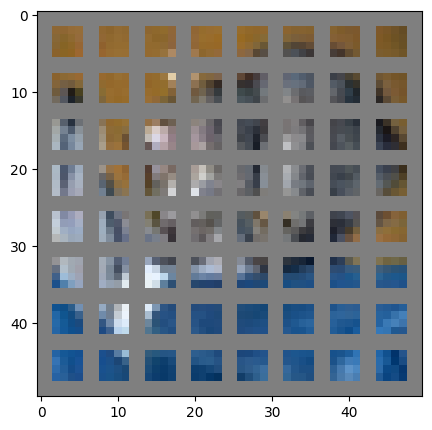

In [135]:
patches = extract_patches(test_image, patch_size=patch_size)
patch_square = patches.reshape(test_image.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_image.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patch_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [136]:
patches.shape

torch.Size([128, 64, 48])

### Model implementation

In [137]:
class TransformerBlock(nn.Module):
    
    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size,  num_heads=num_heads, dropout=0.5,
                                                    batch_first=True)
        
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 2 * hidden_size),
            nn.LayerNorm(2*hidden_size),
            nn.ELU(),
            nn.Linear(2 * hidden_size, hidden_size)
        )
        
    def forward(self, x):
        norm_x = self.norm1(x)
        
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        norm_x = self.norm2(x)
        
        x = self.mlp(norm_x) + x
        return x

In [138]:
class Vit(nn.Module):
    
    def __init__(self, image_size, channels_size, patch_size, hidden_size, num_layers, num_heads=8):
        super(Vit, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_size * patch_size * patch_size, hidden_size)
        
        self.blocks = nn.ModuleList(
            [TransformerBlock(hidden_size=hidden_size, num_heads=num_heads) for _ in range(num_layers)]
        )
        
        self.fc_out = nn.Linear(hidden_size, 10)
        
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
        
        self.seq_len = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, self.seq_len, hidden_size).normal_(std=0.001))
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        patch_sequence = extract_patches(x, self.patch_size)
        patch_embeding = self.fc_in(patch_sequence)        
        patch_embeding = patch_embeding + self.pos_embedding
        
        # Concatenate the output token to the patch embeddings
        embs = torch.cat((self.out_vec.expand(batch_size, 1, -1), patch_embeding), 1)
        
        for block in self.blocks:
            embs = block(embs)
        
        return self.fc_out(embs[:, 0])
        

### Model View

In [139]:
train_images, train_label = next(iter(train_loader))
train_images.shape, train_label.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

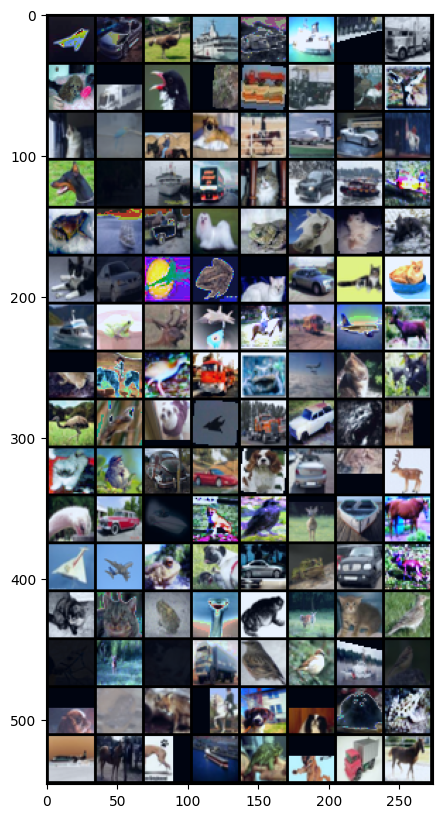

In [140]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [151]:
model = Vit(image_size=32, channels_size=3, patch_size=patch_size, hidden_size=16, num_heads=2, num_layers=2).to(device)
print(model)

Vit(
  (fc_in): Linear(in_features=48, out_features=16, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=True)
        (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=32, out_features=16, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=16, out_features=10, bias=True)
)


In [152]:
num_params = 0
for param in model.parameters():
    num_params += param.flatten().shape[0]

print(f"We have roughtly {num_params} parameters in our vision transformer")

We have roughtly 6570 parameters in our vision transformer


In [153]:
out = model(train_images.to(device))
print(out.shape)

torch.Size([128, 10])


### Set up the remaining learning values

In [154]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                          T_max=num_epochs,
                                                          eta_min=0)

In [155]:
loss_fn = nn.CrossEntropyLoss()

### Training Loop

In [ ]:
def train(model, optimizer, loader, device, loss_fn):
    epoch_acc = 0
    loss_logger = []
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc=False)):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        fx = model(x)
        
        loss = loss_fn(fx, y)
        
        
        loss.backward()
        optimizer.step()
        loss_logger.append(loss.item())
        epoch_acc += (fx.argmax(1) == y).sum().item()
    print("Loss for epoch: ", sum(loss_logger)/len(loss_logger))
    print("Accuracy for epoch", epoch_acc/len(loader.dataset))
    return epoch_acc / len(loader.dataset) , sum(loss_logger)/len(loss_logger)

### Eval loop

In [ ]:
def evaluate(model, loader, device, loss_fn):
    epoch_acc = 0
    epoch_loss = []
    model.eval()
    
    with torch.inference_mode():
        for (x, y) in tqdm(loader, leave=False, desc="Evaluating"):
            x, y = x.to(device), y.to(device)
            fx = model(x)
            epoch_loss.append(loss_fn(fx, y))
            epoch_acc += (fx.argmax(-1) == y).sum().item()
    print("Loss for epoch: ", sum(epoch_loss)/len(epoch_loss))
    print("Accuracy for epoch", epoch_acc/len(loader.dataset))
    return epoch_acc/len(loader.dataset), sum(epoch_loss)/len(epoch_loss)

### Training

In [158]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [159]:
val_acc = 0
train_acc = 0

pbar = tqdm(range(num_epochs), leave=False, desc="Epoch")

for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, val_acc * 100))
    train_acc, train_loss = train(model, optimizer, train_loader, device, loss_fn)
    val_acc, val_loss = evaluate(model, val_loader, device, loss_fn)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    lr_scheduler.step()
print("Training Complete")

Training Complete


In [163]:
test_acc, test_loss = evaluate(model=model, device=device, loader=test_loader, loss_fn=loss_fn)
print("The total test accuracy is: %.2f%%" %(test_acc*100))
print("The total test losss is: %.2f" %(test_loss))

The total test accuracy is: 40.45%
The total test losss is: 1.61


In [ ]:
val_losses = [val.item() for val in val_losses]

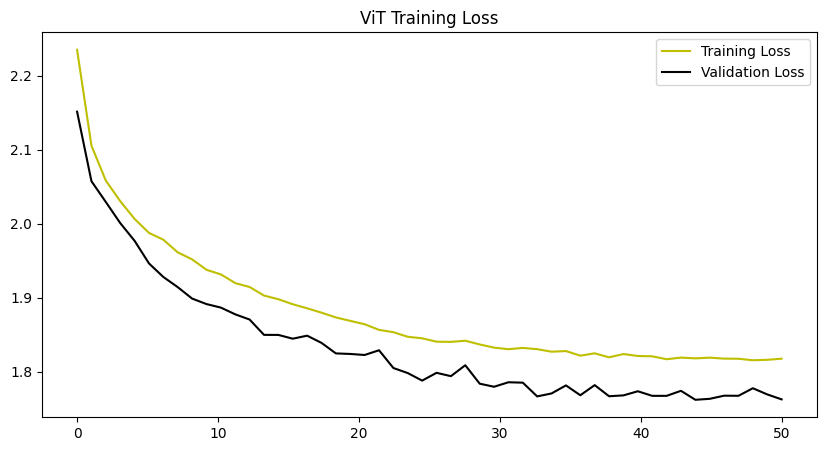

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(train_losses))
plt.plot(train_x, train_losses, c = "y")
valid_x = np.linspace(0, num_epochs, len(val_losses))
plt.plot(valid_x, val_losses, c='k')
plt.title("ViT Training Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

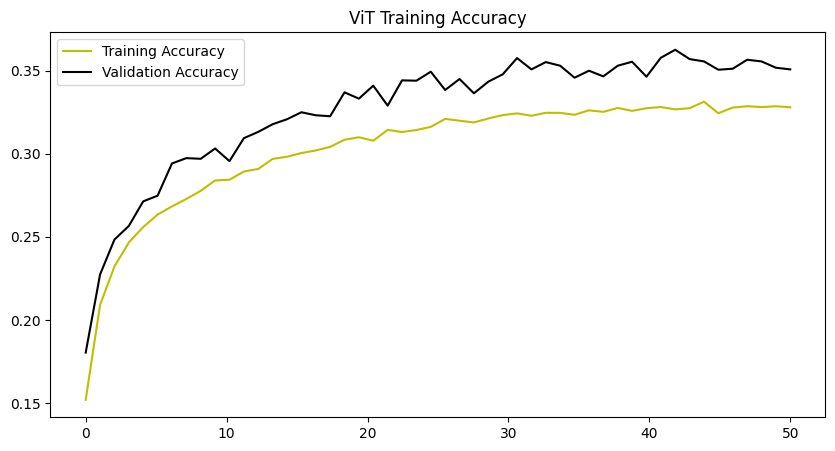

In [172]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(train_accs))
plt.plot(train_x, train_accs, c = "y")
valid_x = np.linspace(0, num_epochs, len(val_accs))
plt.plot(valid_x, val_accs, c='k')
plt.title("ViT Training Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()